<a href="https://colab.research.google.com/github/AlexandraCordeiro/digifolk/blob/main/audio_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython
import numpy as np
import scipy
import requests
from pathlib import Path

In [6]:
# returns an audio times series as an array of floating point numbers representing amplitude
def audio_time_series(audio_path):
  y, sr = librosa.load(audio_path, sr=None, duration=10)
  return y, sr

def display_waveform(y, sr):
  fig,ax = plt.subplots()
  librosa.display.waveshow(y, sr=sr, ax=ax)
  ax.set(title='Amplitude over time')
  plt.xlabel('Time (Seconds)')
  plt.ylabel('Amplitude')
  plt.show()

def rms(y):
  return librosa.feature.rms(y=y, frame_length=2048, hop_length=512)[0]

def download_audio_file(url):
  file = requests.get(url=url).content

  path = Path('data')

  if not path.is_dir():
    path.mkdir()

  file_name = url.split('/')[-1]
  file_dir = path / f'{file_name}'

  with open(file_dir, "wb") as f:
        f.write(file)

  return file_dir

In [7]:
woman_voice = download_audio_file(url='https://github.com/AlexandraCordeiro/digifolk/releases/download/786-itma-woman-voice/786-ITMA-MP3.mp3')
bagpipes = download_audio_file(url='https://github.com/AlexandraCordeiro/digifolk/releases/download/784-itma-pipes/784-ITMA-MP3.mp3')

In [8]:
y, sr = audio_time_series(woman_voice)

print(len(y))
print(sr)

# IPython.display.Audio(y, rate=sr)

480000
48000


In [9]:
# display_waveform(y, sr)

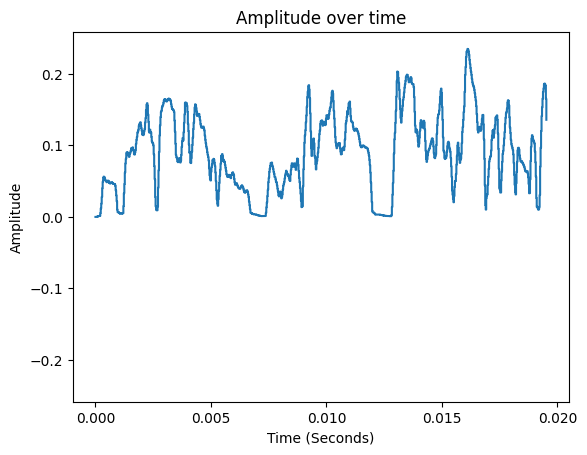

938

In [10]:
rms = rms(y)
display_waveform(rms, sr)
len(rms)

# Feature Extraction

## Spectrogram Visualization

Visualiza a variação de frequências ao longo do tempo assim como a sua intensidade (amplitude) representada através da cor

In [11]:
# Compute Short-Time Fourier Transform (STFT)
D = librosa.stft(y)
# Convert amplitude to decibels
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
print(S_db)

[[-80.       -80.       -80.       ... -69.88863  -53.985474 -38.251472]
 [-80.       -80.       -80.       ... -57.809013 -54.849926 -38.461212]
 [-80.       -80.       -80.       ... -52.96321  -49.06225  -37.06201 ]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -65.70092 ]
 [-80.       -80.       -80.       ... -80.       -80.       -65.701065]
 [-80.       -80.       -80.       ... -80.       -80.       -65.70092 ]]


In [12]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")
plt.show()

## MFCCs (Mel-Frequency Cepstral Coefficients)

MFCCs are widely used in audio analysis, especially in speech and music recognition.

In [13]:
# extract 13 mfccs

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
mfccs

array([[-593.26385  , -593.26385  , -593.26385  , ..., -283.45145  ,
        -252.1508   , -175.12752  ],
       [   0.       ,    0.       ,    0.       , ...,   88.96928  ,
         115.41199  ,  144.62262  ],
       [   0.       ,    0.       ,    0.       , ...,  -13.791997 ,
          -2.9036572,    9.757761 ],
       ...,
       [   0.       ,    0.       ,    0.       , ...,  -45.631462 ,
         -35.969803 ,  -14.27228  ],
       [   0.       ,    0.       ,    0.       , ...,    4.6628704,
          -0.8491116,  -11.740241 ],
       [   0.       ,    0.       ,    0.       , ...,  -10.357883 ,
          -7.909436 ,   -8.4463825]], dtype=float32)

In [14]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.show()

938


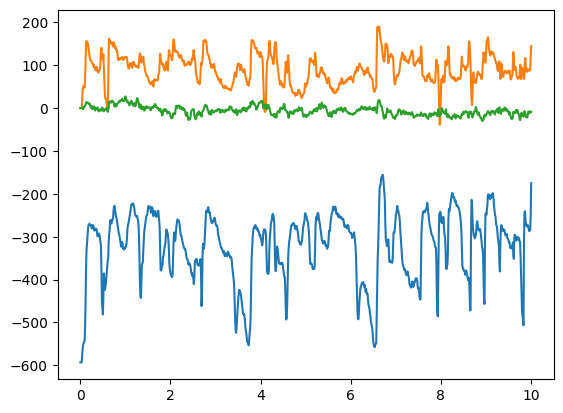

In [15]:
# Plot line graph for each mfcc coeficcient
n_frames = mfccs.shape[1]
print(n_frames)
hop_length = 512  #default
time_axis = np.linspace(0, n_frames * hop_length / sr, num=n_frames)
plt.plot(time_axis, mfccs[0])
plt.plot(time_axis, mfccs[1])
plt.plot(time_axis, mfccs[12])

## Chromagram

In [16]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

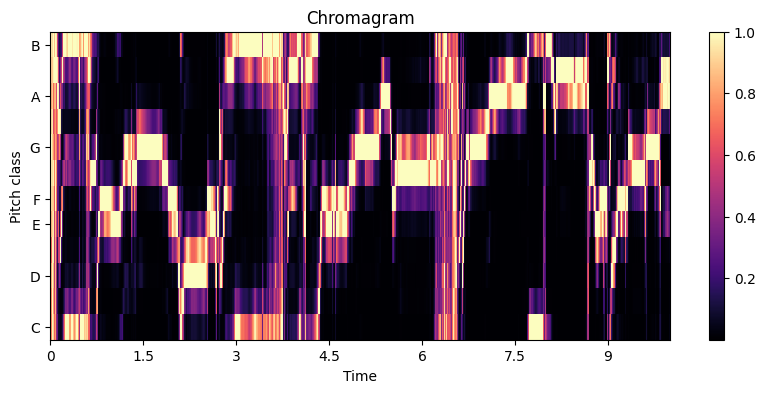

In [17]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.title("Chromagram")
plt.show()

## Harmonic-Percussive Separation

In [18]:
# Separate harmonic and percussive components
y_harmonic, y_percussive = librosa.effects.hpss(y)

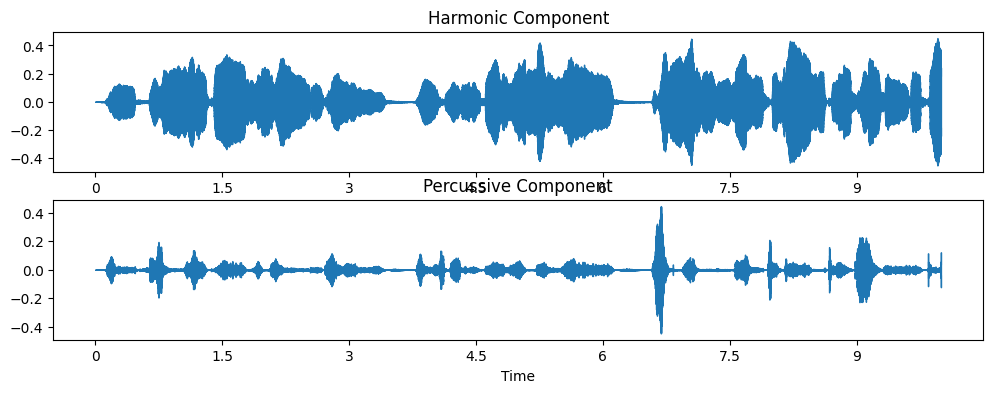

In [19]:
# Display both components
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
librosa.display.waveshow(y_harmonic, sr=sr)
plt.title("Harmonic Component")
plt.subplot(2, 1, 2)
librosa.display.waveshow(y_percussive, sr=sr)
plt.title("Percussive Component")
plt.show()

## Fundamental frequency detection F0

In [20]:
f0, voiced_flag, voiced_probs = librosa.pyin(y,

                                             sr=sr,

                                             fmin=librosa.note_to_hz('C2'),

                                             fmax=librosa.note_to_hz('C7'))

times = librosa.times_like(f0, sr=sr)

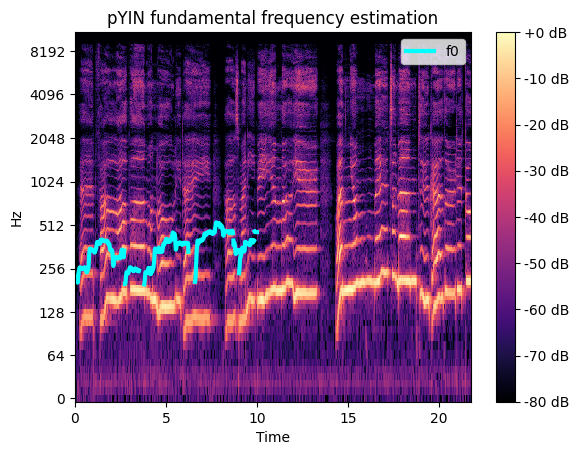

In [21]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

fig, ax = plt.subplots()

img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)

ax.set(title='pYIN fundamental frequency estimation')

fig.colorbar(img, ax=ax, format="%+2.f dB")

ax.plot(times, f0, label='f0', color='cyan', linewidth=3)

ax.legend(loc='upper right')

## Onset Detection

In [22]:
# Detect onsets
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)

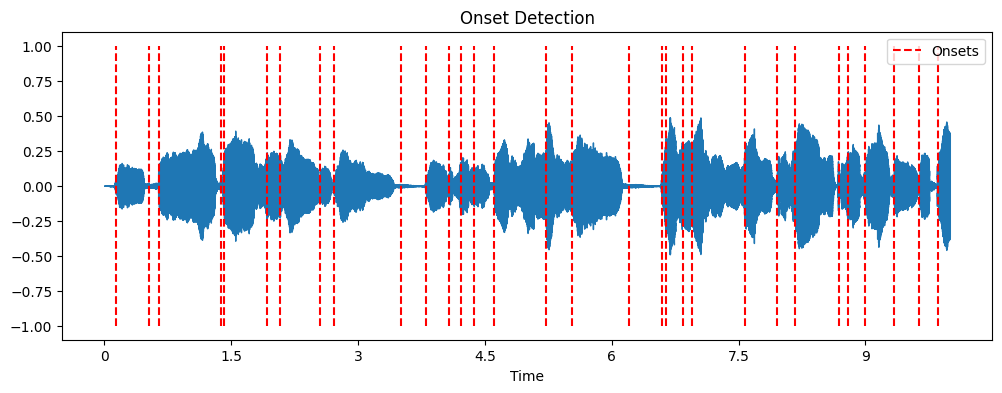

In [23]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.vlines(onset_times, ymin=-1, ymax=1, color='r', linestyle='--', label='Onsets')
plt.legend()
plt.title("Onset Detection")
plt.show()

## Beat Tracking

In [24]:
# Detect beats
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

In [25]:
# Convert beat frames to time
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
print(f"Tempo: {tempo} BPM")
print(f"Beat Times: {beat_times}")

Tempo: [152.02702703] BPM
Beat Times: [0.14933333 0.544      0.96       1.376      1.76       2.15466667
 2.56       2.98666667 3.40266667 3.81866667 4.224      4.62933333
 5.01333333 5.41866667 5.824      6.21866667 6.64533333 7.11466667
 7.584      7.968      8.33066667 8.68266667 8.992      9.33333333
 9.64266667]


## Zero-Crossing Rate

In [26]:
# Calculate zero-crossing rate
zero_crossings = librosa.feature.zero_crossing_rate(y)

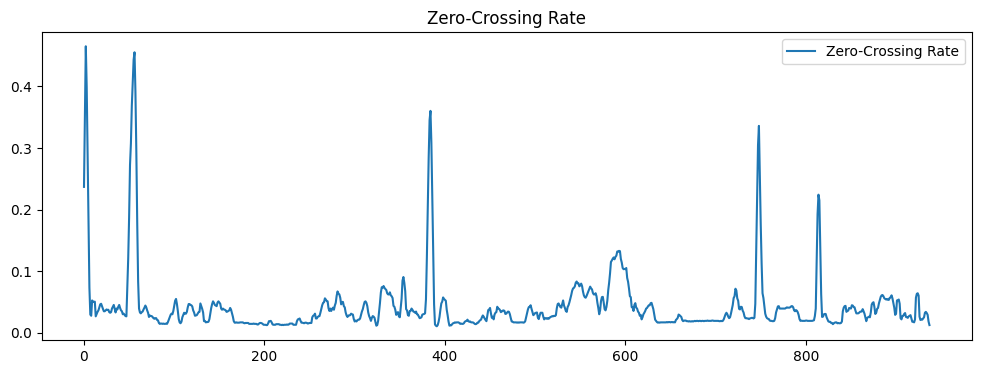

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(zero_crossings[0], label="Zero-Crossing Rate")
plt.legend(loc='upper right')
plt.title("Zero-Crossing Rate")
plt.show()

## Spectral Centroid

In [28]:
# Extract spectral centroid
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

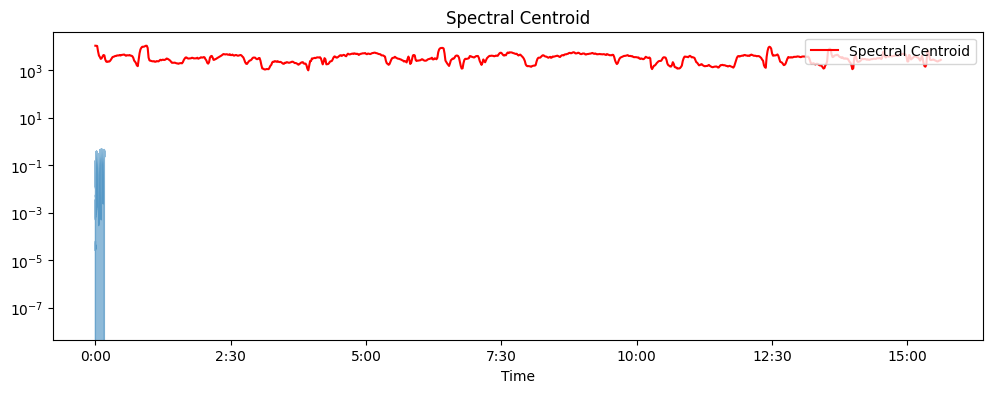

In [29]:
# Plot waveform and spectral centroid
plt.figure(figsize=(12, 4))
plt.semilogy(spectral_centroid, color='r', label='Spectral Centroid')
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.legend(loc='upper right')
plt.title("Spectral Centroid")
plt.show()